#       **1. GENERACIÓN DE LOS PUNTOS DE ENTRENAMIENTO Y VALIDACIÓN A PARTIR DE LOS DATOS DE GEDI**

Una vez resampleados los datos de GEDI, se generan puntos en el centroide de píxeles aleatorios de los transectos generados por la colección. Estos puntos generados, se tranforman en GDF, con los que se extrae el valor de AGBD. Con estos puntos se realiza la estimación y validación del modelo que posteriormente se realizará.

## 1.1. Importar librerias y definir carpeta que contiene los datos

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray as rxr
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.features
from rasterio.plot import plotting_extent
import geopandas as gpd
# Rasterstats contains the zonalstatistics function
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

In [3]:
# --- File paths  ---
root_folder = r"/notebooks/ProyectoFinal/Shapes/"
adi_route = root_folder + "/PNNAmacayacu.shp"
adi = gpd.read_file(adi_route).to_crs(epsg=9377)
gedi_route = root_folder + 'imagenes/gedi.tif'
gedi = rasterio.open(gedi_route)
gedi.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 2424,
 'height': 3539,
 'count': 1,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(25.0, 0.0, 340525.0,
        0.0, -25.0, 9664950.0)}

## 1.2. Exploración de los datos

Raster dimensions (rows, cols): (3539, 2424)
Number of bands: 1
Coordinate reference system (CRS): EPSG:32719
Resolution (pixel size): (25.0, 25.0)
Data type: float64
Min / Max / Mean AGBD: 0.0 / 1061.85376 / 195.93618202012053


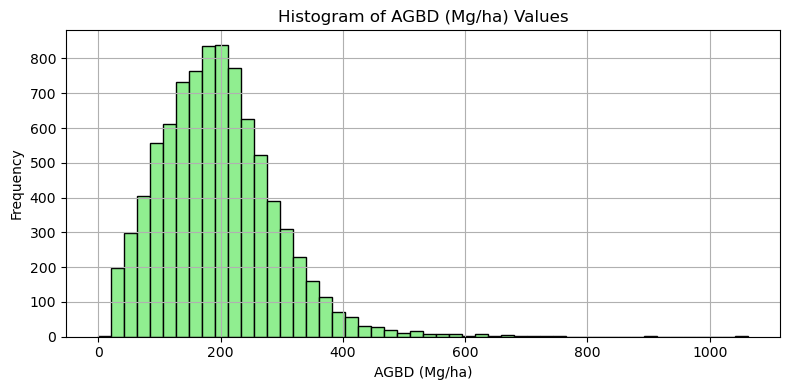

In [4]:
# Explorar los datos de GEDI, generar el histograma para validar la normalidad
# Abre el archivo ráster de forma segura utilizando un gestor de contexto.
# Esto garantiza que el archivo se cierre automáticamente una vez finalizado el bloque.
with rasterio.open(gedi_route) as gedi:
    
    # leer la primera banda
    gedi_data = gedi.read(1).astype(float)
    nodata = gedi.nodata
    transform = gedi.transform
    if nodata is not None:
        gedi_data[gedi_data == nodata] = np.nan

    # obervar los metadatos básicos del ráster
    print("Raster dimensions (rows, cols):", gedi_data.shape)        # Visualizar el raster en pixeles
    print("Number of bands:", gedi.count)                             # Número de bandas en el raster
    print("Coordinate reference system (CRS):", gedi.crs)            # Sistema de coordenadas 
    print("Resolution (pixel size):", gedi.res)                      # Resolución espacial del pixel
    print("Data type:", gedi_data.dtype)                             # tipo de datos (e.g. float32, int16)
    print("Min / Max / Mean AGBD:", np.nanmin(gedi_data), "/", np.nanmax(gedi_data), "/" , np.nanmean(gedi_data))  # Elevation range, ignoring NaNs

    #  Create a histogram to visualise the distribution of elevation values ---
    plt.figure(figsize=(8, 4))
    plt.hist(
        gedi_data[~np.isnan(gedi_data)].flatten(),  # Flatten the array and exclude NaN values
        bins=50,
        color='lightgreen',
        edgecolor='black'
    )
    plt.title("Histogram of AGBD (Mg/ha) Values")
    plt.xlabel("AGBD (Mg/ha)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Se filtraron los datos de GEDI, de acuerdo con distribución de los datos y la literatura, de maneras que se removieran los valores muy elevados de AGDB. De esta manera, se obtuvo un histograma con una ditribución normal de los datos. 

Min / Max / Mean AGBD: 0.0 / 595.509766 / 194.55979446057216
Raster filtrado exportado: /notebooks/ProyectoFinal/Shapes/imagenes/GEDI_filtrado.tif


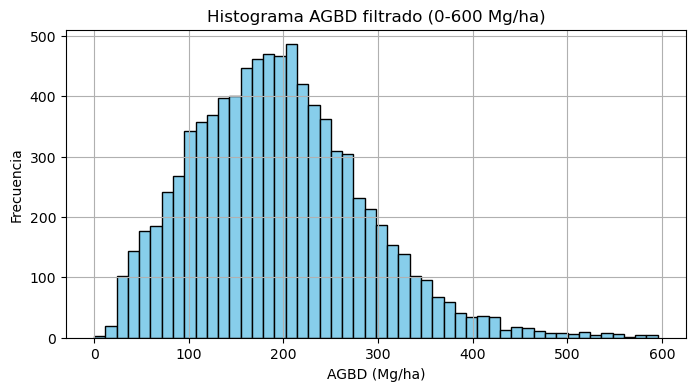

In [10]:
output_raster = root_folder + "imagenes/GEDI_filtrado.tif"

# Abrir y leer el raster
with rasterio.open(gedi_route) as src:
    gedi_data2 = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        gedi_data2[gedi_data2 == nodata] = np.nan
    profile = src.profile

# Definir rango fijo basado en literatura y en la distribución de histograma
min_val, max_val = 0, 600

# Filtrar: mantener solo valores dentro del rango
gedi_data_filtered = np.where((gedi_data2 >= min_val) & (gedi_data2 <= max_val), gedi_data2, np.nan)

# Actualizar perfil para exportar
profile.update(dtype=rasterio.float32, nodata=np.nan)

print("Min / Max / Mean AGBD:", np.nanmin(gedi_data_filtered), "/", np.nanmax(gedi_data_filtered), "/" , np.nanmean(gedi_data_filtered))  # Elevation range, ignoring NaNs


# Guardar nuevo raster
with rasterio.open(output_raster, "w", **profile) as dst:
    dst.write(gedi_data_filtered.astype(rasterio.float32), 1)

print(f"Raster filtrado exportado: {output_raster}")


#  Histograma después del filtrado
plt.figure(figsize=(8, 4))
plt.hist(gedi_data_filtered[~np.isnan(gedi_data_filtered)].flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histograma AGBD filtrado (0-600 Mg/ha)")
plt.xlabel("AGBD (Mg/ha)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


## 1.3. Generación de puntos de entrenamiento

Se generaron 6000 puntos de entrenamiento, apartir de los centroides de píxeles aleatorios de la imagen GEDI. Estos puntos fueron vectorizados, para utilizarlos luego como puntos de entrenamiento y de valdiación del modelo. 

In [11]:
from shapely.geometry import Point
import random

n_points = 6000

# Crear máscara de valores válidos
mask = ~np.isnan(gedi_data_filtered)
if nodata is not None:
    mask &= (gedi_data_filtered != nodata)


# Obtener índices (filas, columnas) de píxeles válidos
rows, cols = np.where(mask)

# Seleccionar aleatoriamente n puntos
indices = random.sample(range(len(rows)), min(n_points, len(rows)))

selected_rows = rows[indices]
selected_cols = cols[indices]

# Calcular coordenadas del centroide de cada píxel
points = []
values = []

for r, c in zip(selected_rows, selected_cols):
    x, y = rasterio.transform.xy(transform, r, c, offset="center")
    points.append(Point(x, y))
    values.append(gedi_data_filtered[r, c])

# Crear GeoDataFrame con CRS del raster
gdf = gpd.GeoDataFrame({"AGBD": values}, geometry=points, crs=gedi.crs)

# Guardar como shapefile o GeoJSON
gdf.to_file(root_folder +"puntos_AGBD5.shp")
print(f"Se generaron {len(gdf)} puntos aleatorios con valores AGBD.")

Se generaron 6000 puntos aleatorios con valores AGBD.


In [12]:
print(gdf["AGBD"].describe())

count    6000.000000
mean      194.865195
std        89.982876
min         0.000000
25%       130.014675
50%       188.918847
75%       247.934223
max       594.286621
Name: AGBD, dtype: float64


## 1.4. Revisión de los puntos de entrenamiento y validación 

Se realizó el histogrma para revisar la distribución de los puntos de entrenamiento y validación, esto permite revisar que la distribución de los datos sea similar a los datos de GEDI con los que se obtuvieron los datos.

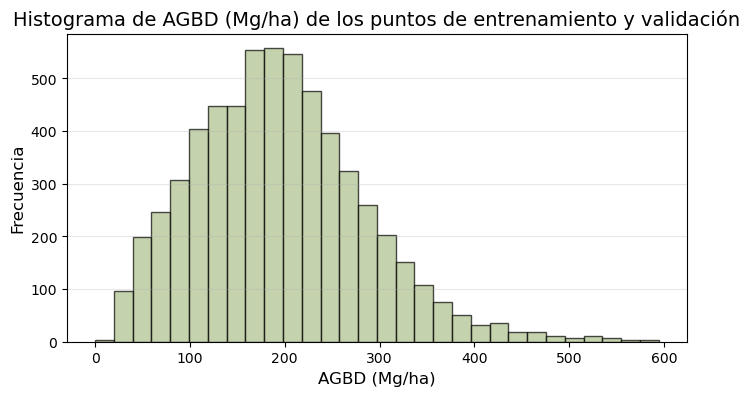

In [13]:
import matplotlib.pyplot as plt

# Histograma
plt.figure(figsize=(8, 4))
plt.hist(gdf["AGBD"], bins=30, color='#acbf8a', edgecolor='black', alpha=0.7)
plt.title("Histograma de AGBD (Mg/ha) de los puntos de entrenamiento y validación", fontsize=14)
plt.xlabel("AGBD (Mg/ha)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()


## 1.5. Visualización de la ditribución de los datos

Se realizó el mapa para visualizar la distribución de los puntos sobre la imagen de GEDI. 

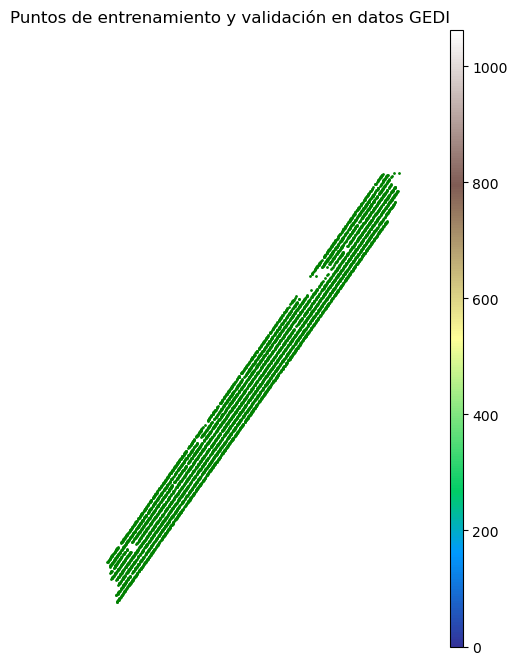

In [14]:
# Definir extent con transform
extent = plotting_extent(gedi_data, transform)

fig, ax = plt.subplots(figsize=(9, 8))

# Plot del raster GEDI
ep.plot_bands(gedi_data,
              extent=extent,
              cmap='terrain',
              title="Puntos de entrenamiento y validación en datos GEDI",
              scale=False,
              ax=ax)

# Plot de los puntos del gdf
gdf.plot(ax=ax, marker='o', markersize=1, color='green')

ax.set_axis_off()
plt.show()